In [1]:
%load_ext autoreload
%autoreload 2

%config InlineBackend.figure_format='retina'

import sys
sys.path.append("../")

In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import scanpy as sc
import scipy

import networkx as nx

In [8]:
sc.settings.set_figure_params(dpi_save=1200, vector_friendly=True, fontsize=18)
plt.rcParams['axes.grid'] = False

In [3]:
from decipher_model import DecipherConfig, Decipher
from load_data import palette_original

from post_analysis import rotate_decipher_space, cluster_representations, compute_trajectories, compute_decipher_time
from post_analysis_plotting import plot_decipher_v, plot_trajectory, plot_gene_patterns, add_cell_type_band

## Load trained model

In [4]:
adata = sc.read_h5ad("data/AML2.decipher.h5ad")
n_genes = adata.shape[1]

cvi_config = DecipherConfig(
    seed=0,
    learning_rate=1e-3,
)
model = Decipher(
    genes_dim=n_genes,
    decipher_config=cvi_config,
)
model.load_state_dict(torch.load("data/AML2.decipher.pth"))
model.eval();


# compatibility - to do in original adata
adata.obsm["decipher_v"] = adata.obsm["latent_p"]
adata.obsm["decipher_z"] = adata.obsm["latent_z"]
adata.obs["origin"] = adata.obs["origin"].replace({"tet2_p1":"AML2", "healthy": "Healthy"})

V4


In [5]:
adata.obs["origin_int"] = adata.obs["origin"].replace({"AML2": 1, "Healthy": 0})
rotate_decipher_space(
    adata, "origin_int", decipher_component_to_align_label_with=2, flip_latent_z=True, flip_decipher_1=True
)

/opt/miniconda3/envs/latent-manifold/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Removing unused categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'origin' as categorical


<AxesSubplot:title={'center':'cell_type_merged'}, xlabel='decipher_v_corrected1', ylabel='decipher_v_corrected2'>

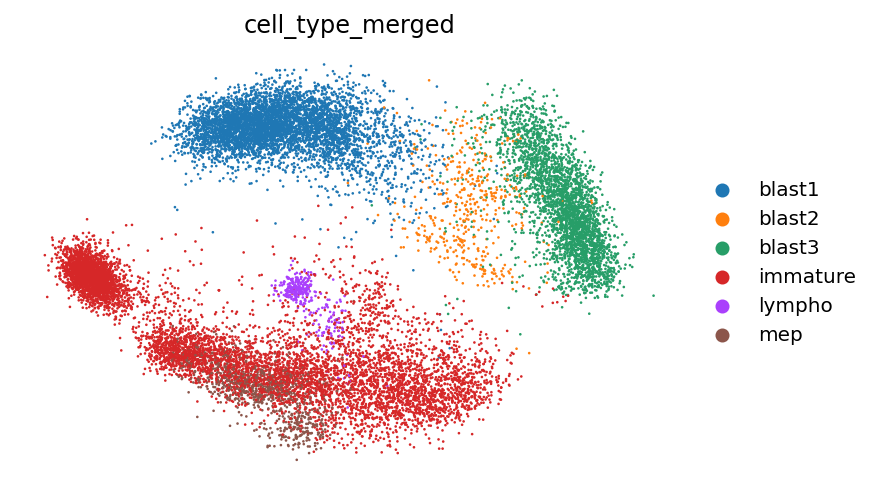

In [6]:
sc.pl.embedding(
        adata,
        basis="decipher_v_corrected",
        color=["cell_type_merged"],
        vmax=lambda xs: np.quantile(xs, 0.95),
        color_map="cool_r",
        frameon=False,
        show=False,
        sort_order=False
    )

/opt/miniconda3/envs/latent-manifold/lib/python3.7/site-packages/ipykernel_launcher.py:14: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  


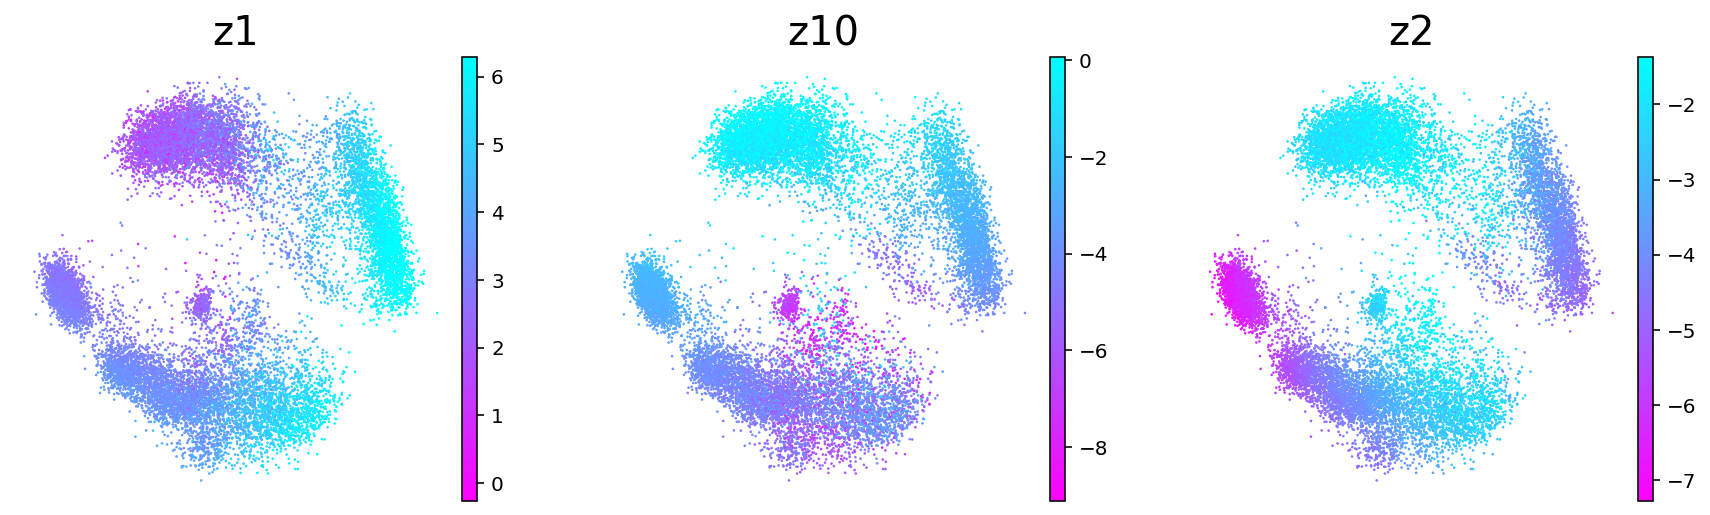

In [7]:
with plt.rc_context({'axes.titlesize':20 , 'axes.labelsize':0, 'figure.figsize': [4,4]}):
    for i in range(10):
        adata.obs["z%d" % (i+1)] = adata.obsm["decipher_z_corrected"][:,i]
    sc.pl.embedding(
        adata,
        basis="decipher_v_corrected",
        color=["z%d" % (i) for i in [1,10,2]],
        vmax=lambda xs: np.quantile(xs, 0.95),
        color_map="cool_r",
        frameon=False,
        show=False,
        sort_order=False
    )
    plt.tight_layout()

# plt.savefig("figures/figure3/figure3.D.part1.pdf")


In [7]:
cluster_representations(adata)
normal_trajectory = compute_trajectories(
    adata,
    "AVP",
    "MPO",
    subset_column="origin",
    subset_value="Healthy",
    cell_types_key="cell_type_merged",
)
perturbed_trajectory = compute_trajectories(
    adata,
    "AVP",
    "CD68",
    subset_column="origin",
    subset_value="AML2",
    cell_types_key="cell_type_merged",
)

In [9]:
sc.write("analysis/AML2.decipher.post-analyzed.h5ad", adata)
import pickle
with open("analysis/AML2.trajectory.normal.pkl", "wb") as f:
    pickle.dump(normal_trajectory, f)
    
with open("analysis/AML2.trajectory.perturbed.pkl", "wb") as f:
    pickle.dump(perturbed_trajectory, f)

Only considering the two last: ['.post-analyzed', '.h5ad'].
Only considering the two last: ['.post-analyzed', '.h5ad'].


In [10]:
adata = sc.read_h5ad("analysis/AML2.decipher.post-analyzed.h5ad")
import pickle
with open("analysis/AML2.trajectory.normal.pkl", "rb") as f:
    normal_trajectory = pickle.load(f)
    
with open("analysis/AML2.trajectory.perturbed.pkl", "rb") as f:
    perturbed_trajectory = pickle.load(f)

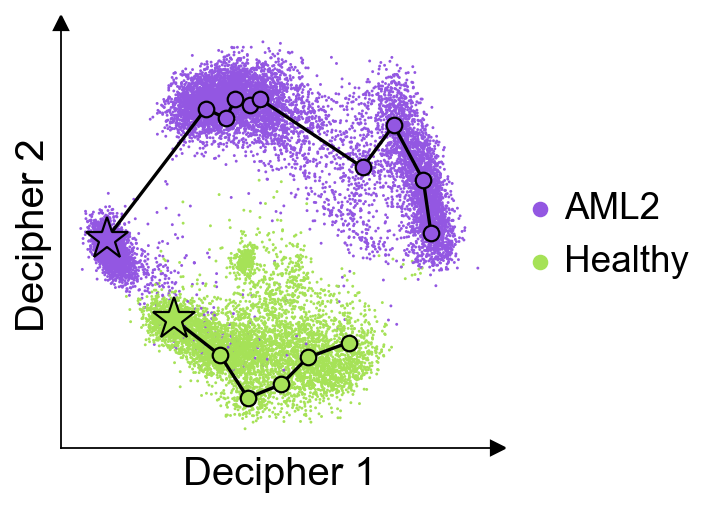

In [12]:
fig = plot_decipher_v(adata, "origin", palette=palette_original)
plot_trajectory(
    fig.axes[0],
    normal_trajectory,
    color=palette_original["Healthy"],
)

plot_trajectory(
    fig.axes[0],
    perturbed_trajectory,
    color=palette_original["AML2"],
)
fig.savefig("figures/extended_figure3/AML2.decipher_space.origin.pdf", bbox_inches="tight")

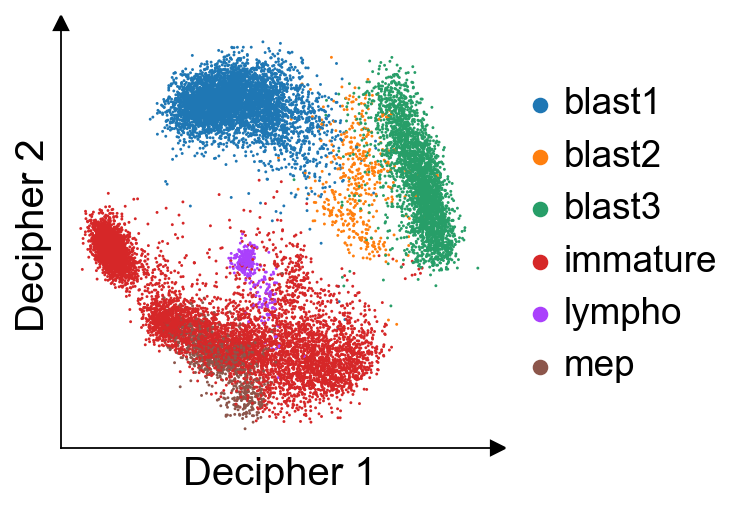

In [13]:
fig = plot_decipher_v(adata, "cell_type_merged")
fig.savefig("figures/extended_figure3/AML2.decipher_space.cell_type.pdf", bbox_inches="tight")

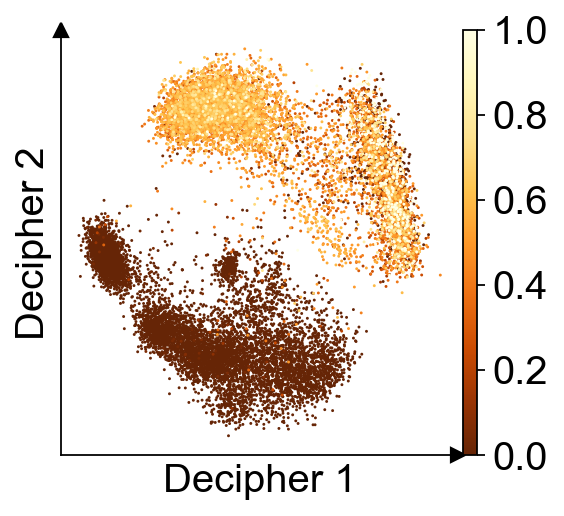

In [14]:
fig = plot_decipher_v(adata, "NPM1 mutation vs wild type", cmap=sns.color_palette("YlOrBr_r", as_cmap=True, ))
fig.savefig("figures/extended_figure3/AML2.decipher_space.mutation.pdf", bbox_inches="tight")

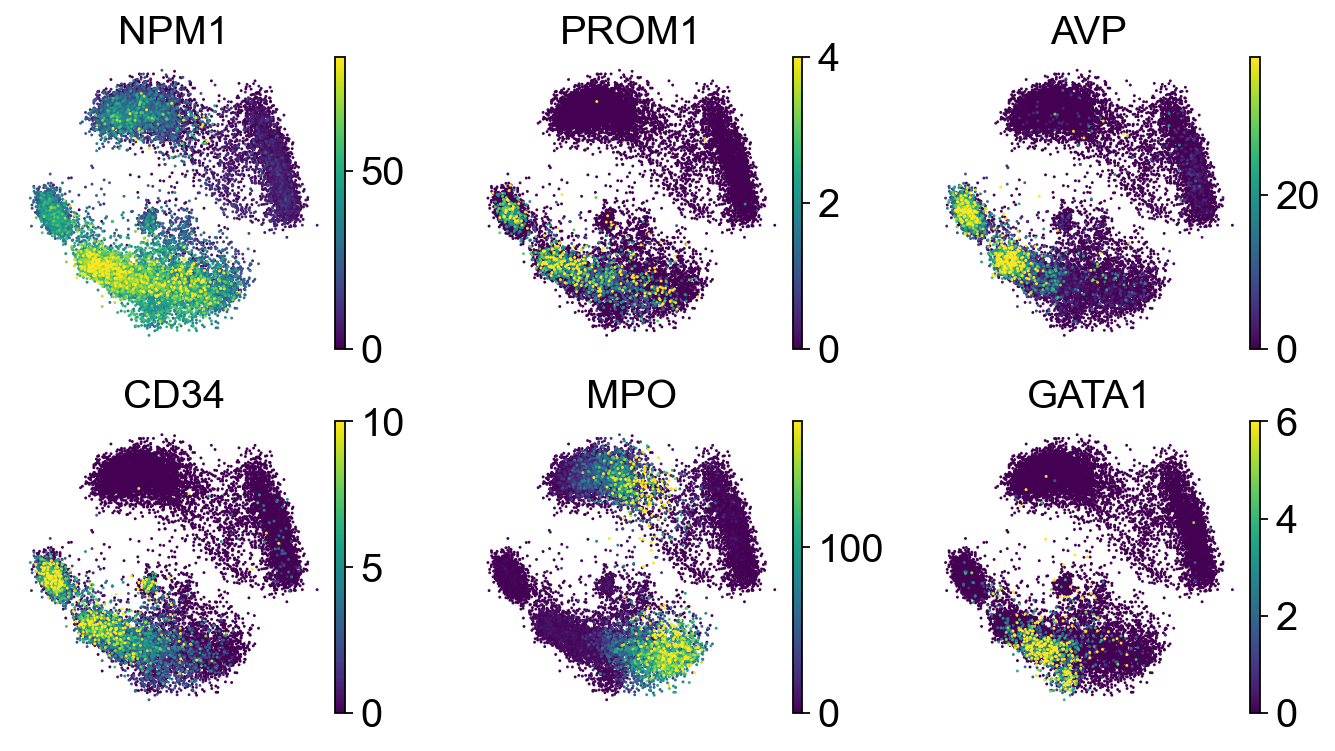

In [15]:
fig = plot_decipher_v(
    adata,
    ["NPM1", "PROM1", "AVP", "CD34", "MPO", "GATA1"],
    show_axis="no",
    ncols=3,
    vmax=lambda x: np.quantile(x, 0.99),
    figsize=(2.5, 2.5),
)
fig.savefig("figures/extended_figure3/AML2.decipher_space.gene_expression.pdf", bbox_inches='tight')

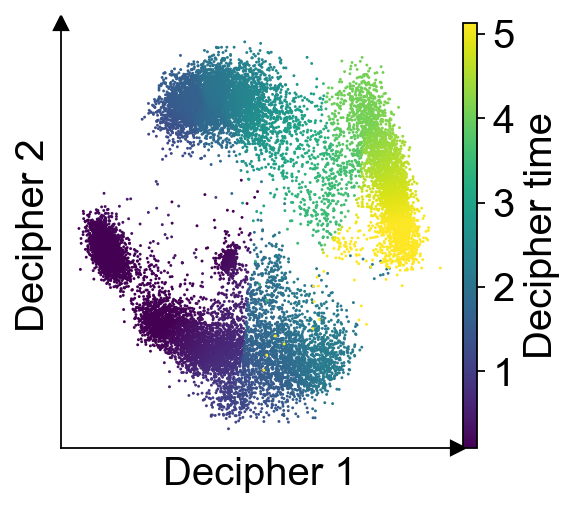

In [16]:
compute_decipher_time(
    adata, {"Healthy": normal_trajectory, "AML2": perturbed_trajectory}
)

fig = plot_decipher_v(adata, "decipher_time")
fig.axes[0].collections[-1].colorbar.set_label("Decipher time")
fig.axes[0].collections[-1].colorbar.set_ticks([0,1,2,3,4,5])
fig.savefig("figures/extended_figure3/AML2.decipher_space.decipher_time.pdf", bbox_inches='tight')

In [17]:
from post_analysis import gene_patterns_from_decipher_trajectory

gene_patterns_from_decipher_trajectory(adata, model)

# we now compare patterns only on their overlapping portions
reference_times = None
min_length = 1_000_000
gene_patterns = []
keys = []
for key in adata.uns["decipher_gene_patterns"]:
    keys.append(key)
    patterns_df = adata.uns["decipher_gene_patterns"][key].T
    if patterns_df.shape[1] < min_length:
        reference_times = patterns_df.columns.values
        min_length = patterns_df.shape[1]
    gene_patterns.append(patterns_df.values)

gene_patterns = np.stack([gg[:, :min_length] for gg in gene_patterns])
adata.uns["decipher_gene_patterns_cropped"] = {
    "patterns": gene_patterns,
    "times": reference_times,
    "keys": keys,
}

In [22]:
from basis_decomposition.run import compute_basis_decomposition, InferenceMode, plot_basis, get_basis

gene_patterns = torch.FloatTensor(adata.uns["decipher_gene_patterns_cropped"]["patterns"])
gene_patterns_times = torch.FloatTensor(adata.uns["decipher_gene_patterns_cropped"]["times"])

trajectory_model, guide, times, samples, gene_scales = compute_basis_decomposition(
    gene_patterns,
    InferenceMode.GAUSSIAN_BETA_ONLY,
    n_basis=5,
    n_iter=10_000,
    show_basis=False,
    lr=1e-2,
    beta_prior=1,
    seed=0,
    times=gene_patterns_times
)
gene_scales = gene_scales.detach().numpy()
betas = samples["beta"]["mean"].squeeze().detach().numpy()
basis = get_basis(trajectory_model, guide, gene_patterns, times)
adata.uns["decipher_basis_decomposition"] = {"scales": gene_scales, "betas": betas, "basis": basis}

[iteration 0001] loss: 435679.0450 0.430704802274704 tensor(0.3003)
[iteration 0101] loss: 131916.0108 0.23019465804100037 tensor(0.1605)
[iteration 0201] loss: 44417.5800 0.2040376365184784 tensor(0.1423)
[iteration 0301] loss: -137636.5277 0.07903185486793518 tensor(0.0551)
[iteration 0401] loss: -378681.8246 0.019366884604096413 tensor(0.0135)
[iteration 0501] loss: -525054.2496 0.00880528800189495 tensor(0.0061)
[iteration 0601] loss: -597806.2415 0.006302881985902786 tensor(0.0044)
[iteration 0701] loss: -639922.6765 0.005133643746376038 tensor(0.0036)
[iteration 0801] loss: -669838.4554 0.003333922941237688 tensor(0.0023)
[iteration 0901] loss: -700938.4273 0.002715102629736066 tensor(0.0019)
[iteration 1001] loss: -721717.0409 0.00238507310859859 tensor(0.0017)
[iteration 1101] loss: -735099.4621 0.0022028861567378044 tensor(0.0015)
[iteration 1201] loss: -746943.5885 0.002063007326796651 tensor(0.0014)
[iteration 1301] loss: -752721.6337 0.0020059726666659117 tensor(0.0014)
[it

In [24]:
sc.write("analysis/AML2.decipher.post-analyzed.h5ad", adata)


Only considering the two last: ['.post-analyzed', '.h5ad'].
Only considering the two last: ['.post-analyzed', '.h5ad'].


Text(0.5, 0, 'Decipher time')

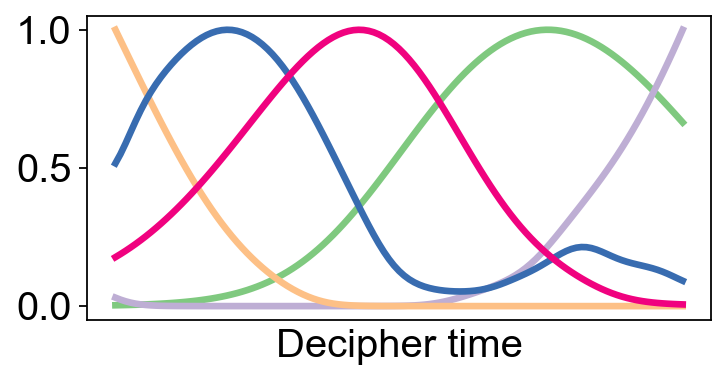

In [25]:
with plt.rc_context({"figure.figsize": [5,2.5]}):
    colors = sns.color_palette("Accent")
    colors = [colors[i] for i in [0, 1, 2, 4, 5]]
    plot_basis(trajectory_model, guide, gene_patterns, times, colors);
plt.xticks([])
plt.xlabel("Decipher time")
# plt.savefig(f"figures/figure3/AML2.basis.pdf",  bbox_inches="tight")

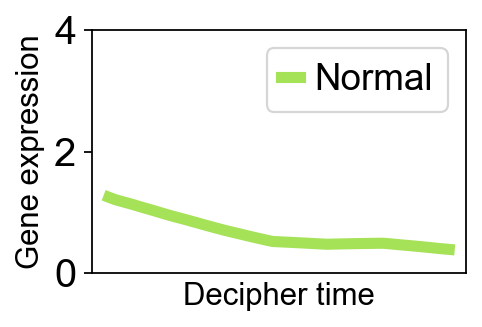

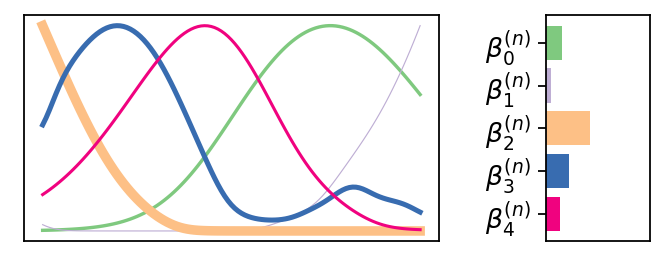

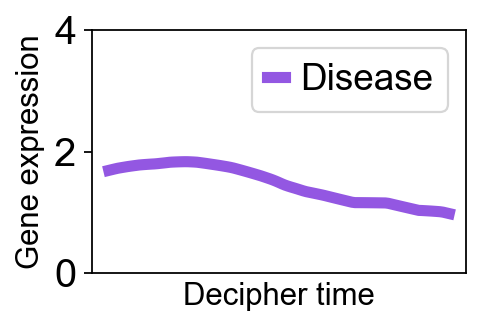

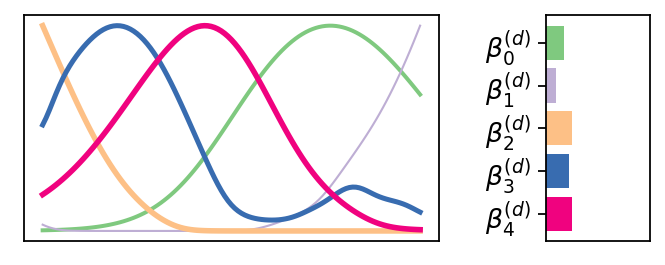

In [28]:
gene_name = "HOXA9"
g_id = adata.var_names.tolist().index(gene_name)
c = 1
for c in range(2):
    plt.figure(figsize=(3, 2))
    plt.plot(
        gene_patterns[c, g_id],
        label=["Normal", "Disease"][c],
        color=["#A6E257", "#9357E2"][c],
        linewidth=5,
    )
    plt.xticks([])
    plt.xlabel("Decipher time", fontsize=14)
    plt.ylabel("Gene expression", fontsize=14)
    plt.legend()
    plt.ylim(0, 4)
#     plt.savefig(
#         f"figures/figure1/AML1.gene_pattern.{['normal', 'disease'][c]}.{gene_name}.pdf",
#         bbox_inches="tight",
#     )

    fig, axes = plt.subplots(
        1, 2, gridspec_kw={"width_ratios": [4, 1]}, figsize=[4.5, 2]
    )
    colors = sns.color_palette("Accent")
    colors = [colors[i] for i in [0, 1, 2, 4, 5]]
    ax = axes[0]
    for i in range(5):
        ax.plot(
            basis[:, i],
            c=colors[i],
            label="$b_%d$" % i,
            linewidth=betas[c, g_id, i] * 10,
        )

    #     ax.axis(False)
    ax.set_xticks([])
    ax.set_yticks([])

    ax = axes[1]
    ax.barh(y=range(5)[::-1], width=betas[c, g_id], color=colors)

    ax.set_yticks(range(5)[::-1])
    ax.set_xlim(0, 1)
    ax.set_yticklabels(
        [f"$\\beta^{{({'nd'[c]})}}_%d$" % i for i in range(5)], fontsize=12
    )
    #     for k in ax.spines:
    #         ax.spines[k].set_visible(False)
    #     ax.xaxis.set_visible(False)
    ax.set_xticks([])
    fig.tight_layout()
#     plt.savefig(
#         f"figures/figure1/AML1.basis_decomposition.{['normal', 'disease'][c]}.{gene_name}.pdf",
#         bbox_inches="tight",
#     )

In [16]:
n_samples = 100
normal_gene_patterns_samples = sample_from_decipher_trajectory(
    adata, model, normal_trajectory.trajectory_latent, n_samples=n_samples, smooth=0
)
perturbed_gene_patterns_samples = sample_from_decipher_trajectory(
    adata, model, perturbed_trajectory.trajectory_latent, n_samples=n_samples, smooth=0
)


normal_gene_patterns_mean = sample_from_decipher_trajectory(
    adata, model, normal_trajectory.trajectory_latent, smooth=0, return_mean=True
).T
perturbed_gene_patterns_mean = sample_from_decipher_trajectory(
    adata, model, perturbed_trajectory.trajectory_latent, smooth=0, return_mean=True
).T
min_length = min(normal_gene_patterns_mean.shape[1], perturbed_gene_patterns_mean.shape[1])

gene_patterns = torch.stack(
    [
        normal_gene_patterns_mean[:, :min_length], 
        perturbed_gene_patterns_mean[:, :min_length],
    ]
)
gene_patterns_raw = gene_patterns.clone()
gene_patterns = (
    gene_patterns - gene_patterns.mean(axis=[0,2], keepdim=True)
) / gene_patterns.std(axis=[0,2], keepdim=True)

torch.save(
    {"gene_patterns_zscore": gene_patterns, "gene_patterns_raw": gene_patterns_raw},
    "AML2.gene_patterns.pt",
)

Text(0.5, 0, 'Decipher time')

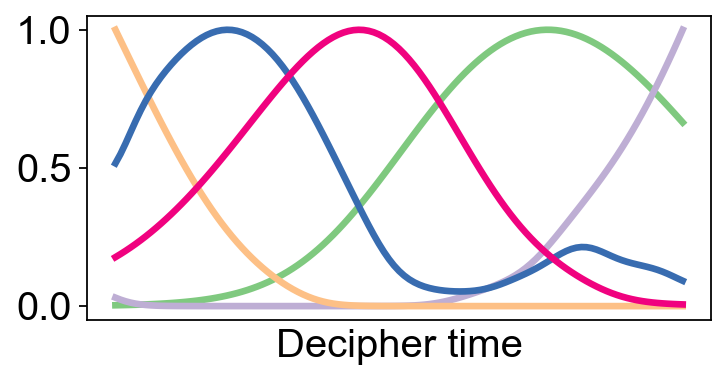

In [23]:
with plt.rc_context({"figure.figsize": [5,2.5]}):
    colors = sns.color_palette("Accent")
    colors = [colors[i] for i in [0, 1, 2, 4, 5]]
    basis = plot_basis(trajectory_model, guide, gene_patterns, times, colors);
plt.xticks([])
plt.xlabel("Decipher time")
# plt.savefig(f"figures/figure3/AML2.basis.pdf",  bbox_inches="tight")

adata.varm['trajectory_basis_healthy'] = samples["beta"]["mean"].squeeze().numpy()[0]
adata.varm['trajectory_basis_disease'] = samples["beta"]["mean"].squeeze().numpy()[1]




disruption_scores = np.diag(
    scipy.spatial.distance.cdist(
        samples["beta"]["values"].squeeze().mean(0)[0],
        samples["beta"]["values"].squeeze().mean(0)[1],
    )
)
adata.var["disruption_score"] = disruption_scores

sc.write("analysis/AML2.decipher.post-analyzed.h5ad", adata)

import pickle
with open("analysis/AML2.trajectory.normal.pkl", "wb") as f:
    pickle.dump(normal_trajectory, f)
    
with open("analysis/AML2.trajectory.perturbed.pkl", "wb") as f:
    pickle.dump(perturbed_trajectory, f)